SCIP status:presolving:
 optimal
Total generation cost: 67860.00 €
(round 1, fast)       36 del vars, 0 del conss, 0 add conss, 14 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, fast)       46 del vars, 0 del conss, 0 add conss, 14 chg bounds, 16 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 3, fast)       63 del vars, 16 del conss, 0 add conss, 23 chg bounds, 16 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 4, fast)       72 del vars, 16 del conss, 0 add conss, 44 chg bounds, 16 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 5, fast)       95 del vars, 16 del conss, 0 add conss, 44 chg bounds, 24 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 6, fast)       95 del vars, 24 del conss, 0 add conss, 45 chg bounds, 24 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
presolving (7 rounds: 7 fast, 1 medium, 1 exhaustive):
 96 deleted vars, 24 deleted constraints, 0 added constraints, 45 tight

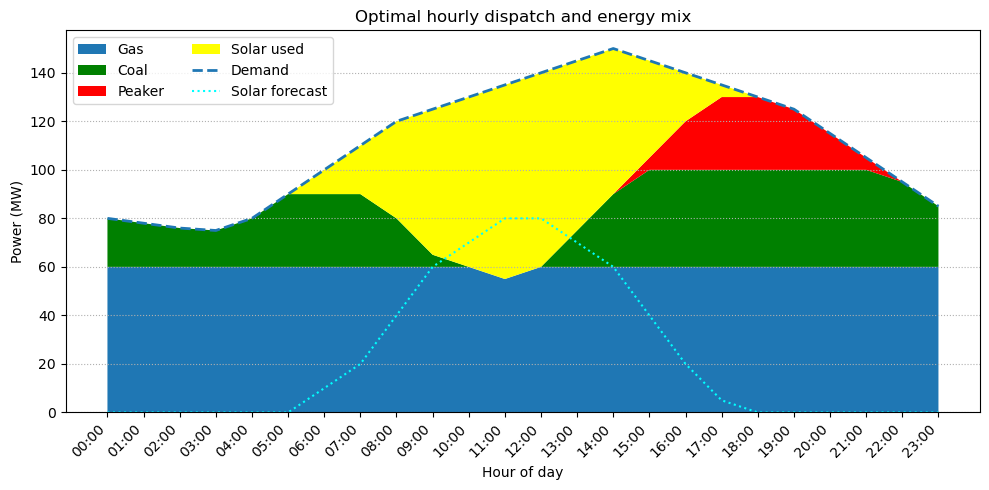

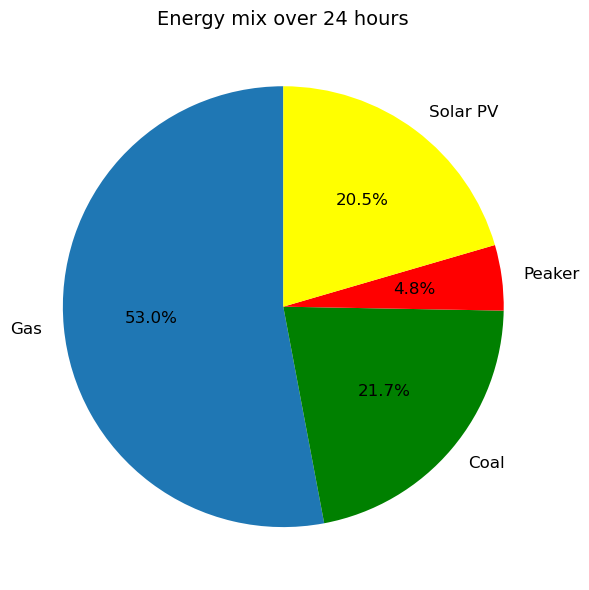

In [10]:
from pyscipopt import Model, quicksum
import matplotlib.pyplot as plt
import numpy as np

# ==========================
# Data
# ==========================

# Dispatchable technologies
techs = ["Gas", "Coal", "Peaker"]

cost = {    # €/MWh
    "Gas": 20,
    "Coal": 40,
    "Peaker": 120,
}

pmax = {    # MW
    "Gas": 60,
    "Coal": 40,
    "Peaker": 100,
}

# Time index: 24 hours (hourly)
T = range(24)
hours_labels = [f"{h:02d}:00" for h in T]

# Hourly demand (MW)
D = {
    0:  80,  1:  78,  2:  76,  3:  75,
    4:  80,  5:  90,  6: 100,  7: 110,
    8: 120,  9: 125, 10: 130, 11: 135,
    12: 140, 13: 145, 14: 150, 15: 145,
    16: 140, 17: 135, 18: 130, 19: 125,
    20: 115, 21: 105, 22:  95, 23:  85,
}

# Hourly solar PV forecast (MW)
S = {
    0:   0,  1:  0,  2:  0,  3:  0,
    4:   0,  5:  0,  6: 10,  7: 20,
    8:  40,  9: 60, 10: 70, 11: 80,
    12: 80, 13: 70, 14: 60, 15: 40,
    16: 20, 17:  5, 18:  0, 19:  0,
    20:  0, 21:  0, 22:  0, 23:  0,
}

# Duration of each time-step (h)
Delta = 1.0

# ==========================
# Model
# ==========================

m = Model("multi_period_dispatch")

# Variables: u[i,t] for dispatchable tech, upv[t] for solar actually used
u = {}
for i in techs:
    for t in T:
        u[i, t] = m.addVar(lb=0.0, ub=pmax[i], name=f"u_{i}_{t}")

upv = {}
for t in T:
    upv[t] = m.addVar(lb=0.0, ub=S[t], name=f"upv_{t}")

# Power balance at each time-step
for t in T:
    m.addCons(
        quicksum(u[i, t] for i in techs) + upv[t] == D[t],
        name=f"balance_{t}",
    )

# Objective: minimize total production cost
m.setObjective(
    quicksum(cost[i] * u[i, t] * Delta for i in techs for t in T),
    sense="minimize",
)

# Solve
m.optimize()

status = m.getStatus()
print("SCIP status:", status)
if status not in ["optimal", "bestsollimit"]:
    print("Warning: solution is not proven optimal.")

obj = m.getObjVal()
print(f"Total generation cost: {obj:.2f} €")

# ==========================
# Extract solution
# ==========================

gen = {i: [] for i in techs}
pv_used = []

for t in T:
    for i in techs:
        gen[i].append(m.getVal(u[i, t]))
    pv_used.append(m.getVal(upv[t]))

# Convert to numpy arrays (useful for plotting)
gen_arrays = {i: np.array(gen[i]) for i in techs}
pv_used = np.array(pv_used)
demand = np.array([D[t] for t in T])
solar_forecast = np.array([S[t] for t in T])

# ==========================
# Visualization: Energy dispatch
# ==========================

fig, ax = plt.subplots(figsize=(10, 5))

# Stacked area of dispatchable generation + solar used
ax.stackplot(
    T,
    gen_arrays["Gas"],
    gen_arrays["Coal"],
    gen_arrays["Peaker"],
    pv_used,
    labels=["Gas", "Coal", "Peaker", "Solar used"],
    colors = ["tab:blue", "green", "red", "yellow"]
    # step="mid",
)

# Plot demand as a line
ax.plot(T, demand, linestyle="--", linewidth=2, label="Demand")

# Show solar forecast as dotted line
ax.plot(T, solar_forecast, linestyle=":", linewidth=1.5, color="cyan", label="Solar forecast")

ax.set_xticks(T)
ax.set_xticklabels(hours_labels, rotation=45, ha="right")
ax.set_xlabel("Hour of day")
ax.set_ylabel("Power (MW)")
ax.set_title("Optimal hourly dispatch and energy mix")
ax.legend(loc="upper left", ncol=2)
ax.grid(True, axis="y", linestyle=":")

plt.tight_layout()
plt.savefig("dispatch_multi_independent.png")
plt.show()

# ==========================
# Visualization: Energy mix pie chart (colors matched)
# ==========================

# Total energy (MWh)
energy_gas    = gen_arrays["Gas"].sum()    * Delta
energy_coal   = gen_arrays["Coal"].sum()   * Delta
energy_peaker = gen_arrays["Peaker"].sum() * Delta
energy_solar  = pv_used.sum()              * Delta

labels = ["Gas", "Coal", "Peaker", "Solar PV"]
colors = ["tab:blue", "green", "red", "yellow"]
sizes  = [energy_gas, energy_coal, energy_peaker, energy_solar]

fig2, ax2 = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax2.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 12}
)

ax2.set_title("Energy mix over 24 hours", fontsize=14)
ax2.axis("equal")

plt.tight_layout()
plt.savefig("dispatch_multi_independent_energy_mix_pie.png")
plt.show()